In [3]:
############################
## Load required packages ##
############################

import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
###############
## Load data ##
###############

print('\n(1) Loading intermediate dataset\n')

# Name and location of intermediate dataset
abs_dir = os.getcwd()
rel_dir = '../../data/covid19_DTM/interim/QALY_model/postponement_non_covid_care/UZG/MZG_2016_2021.csv'
# Name and location of saved dataframe
result_folder =  '../../data/covid19_DTM/interim/QALY_model/postponement_non_covid_care/UZG'
# Load data
df = pd.read_csv(os.path.join(abs_dir, rel_dir), index_col=[0,1,2,3], parse_dates=True)
# Sum to weekly frequency to reduce noise in the dataset
df = df.reset_index().dropna().groupby(by=['APR_MDC_key', 'date']).sum().sort_index()


(1) Loading intermediate dataset



In [89]:
############################################################
## Construct baseline dataframe using data from 2017-2019 ##
############################################################

bootstrap_repeats = 5
subset_size=5

print('\n(2) Constructing baseline dataframe using data from 2016-2020\n')

# Define a target dataframe containing the week and day number instead of the date
month_numbers = list(range(1,12+1))
day_numbers = list(range(1,31+1))
iterables=[]
names=[]
for index_name in df.index.names:
    if index_name != 'date':
        iterables += [df.index.get_level_values(index_name).unique()]
        names += [index_name,]
iterables.append(month_numbers)
iterables.append(day_numbers)
names.append('month_number')
names.append('day_number')
# Add bootstrap axis
iterables.append(list(range(bootstrap_repeats)))
names.append('bootstrap_sample')
index = pd.MultiIndex.from_product(iterables, names=names)
baseline_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))
# Use all data from the jan. 2016 until jan. 2020 as baseline
baseline = df[((df.index.get_level_values('date')<pd.Timestamp('2020-01-01'))&(df.index.get_level_values('date')>=pd.Timestamp('2016-01-01')))]

names=['month_number', 'day_number']
iterables=[baseline_df.index.get_level_values('month_number').unique(), baseline_df.index.get_level_values('day_number').unique()]
index = pd.MultiIndex.from_product(iterables, names=names)
merge_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))

# Loop over all possible indices, convert date to day of year, take average of values with same day-of-year number
with tqdm(total=len(baseline.index.get_level_values('APR_MDC_key').unique())*bootstrap_repeats) as pbar:
    for APR_MDC_key in baseline.index.get_level_values('APR_MDC_key').unique():
        for idx in baseline_df.index.get_level_values('bootstrap_sample').unique():
            # Extract dataseries
            data = baseline.loc[(APR_MDC_key,),:]
            # Reset index to 'unlock' the date
            data.reset_index(inplace=True)
            # Convert the date to week and day number
            #data['month_number'] = pd.to_datetime(data['date'].values).isocalendar().week.values
            #data['day_number'] = pd.to_datetime(data['date'].values).isocalendar().day.values
            data['month_number'] = pd.to_datetime(data['date']).dt.month.values
            data['day_number'] = pd.to_datetime(data['date']).dt.day.values
            # Perform a groupby 'date' operation with mean() to take the mean of all values with similar daynumber
            d = data.groupby(by=['month_number','day_number']).apply(lambda x: np.mean(x['n_patients'].sample(n=subset_size, replace=True)))
            d.name = 'n_patients'
            baseline_df.loc[APR_MDC_key, slice(None), slice(None), idx] = pd.merge(d, merge_df, how='right', on=['month_number','day_number']).fillna(method='ffill')['n_patients_x'].values   
            pbar.update(1)


(2) Constructing baseline dataframe using data from 2016-2020



100%|██████████| 140/140 [00:21<00:00,  6.42it/s]


In [76]:
data

,date,n_patients,month_number,day_number
0,2016-01-01,22,1,1
1,2016-01-02,22,1,2
2,2016-01-03,22,1,3
3,2016-01-04,22,1,4
4,2016-01-05,23,1,5
...,...,...,...,...
1456,2019-12-27,18,12,27
1457,2019-12-28,16,12,28
1458,2019-12-29,16,12,29
1459,2019-12-30,17,12,30


<AxesSubplot:xlabel='month_number,day_number'>

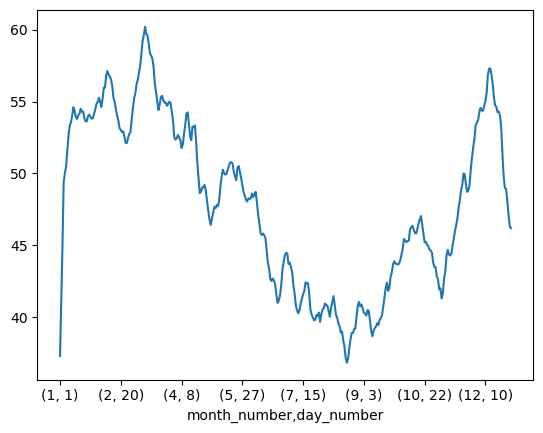

In [87]:
baseline_df['04'].groupby(['month_number','day_number']).mean().ewm(7).mean().plot()

<AxesSubplot:xlabel='date'>

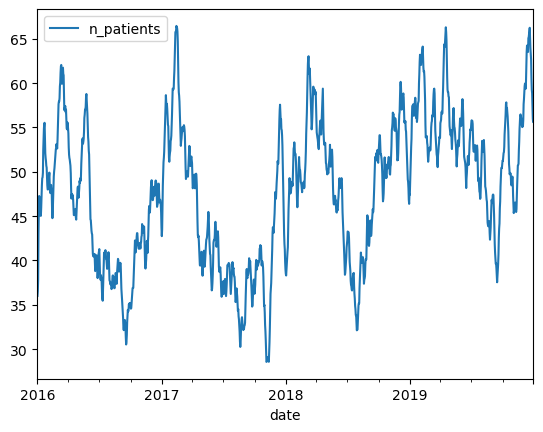

In [88]:
baseline.loc['04'].ewm(7).mean().plot()

In [ ]:
#################
## Save result ##
#################

print('\n(4) Saving result\n')

baseline.to_csv(os.path.join(abs_dir, result_folder,'baseline.csv'))

In [ ]:
#####################################################################
## Normalizing pandemic data (2020-2021) with prepandemic baseline ##
#####################################################################

print('\n(3) Normalizing pandemic data (2020-2021) with prepandemic baseline\n')

# Consider all data from the beginning of 2020 as the actual 'data'
data_df = df[df.index.get_level_values('date')>=pd.Timestamp('2020-01-01')]
# Initialize target dataframe
iterables=[data_df.index.get_level_values('APR_MDC_key').unique(), data_df.index.get_level_values('date').unique(), list(range(bootstrap_repeats))]
names=['APR_MDC_key', 'date', 'bootstrap_sample']
index = pd.MultiIndex.from_product(iterables, names=names)
target_df = pd.Series(index=index, name='rel_hospitalizations', data=np.zeros(len(index), dtype=int))

# Loop over all possible indices, convert date to day of year, take average of values with same day-of-year number
with tqdm(total=len(data_df.index.get_level_values('APR_MDC_key').unique())*bootstrap_repeats) as pbar:
    for APR_MDC_key in data_df.index.get_level_values('APR_MDC_key').unique():
        for idx in baseline_df.index.get_level_values('bootstrap_sample').unique():
            # Extract dataseries
            data = data_df.loc[(APR_MDC_key,),:]
            # Reset index to 'unlock' the date
            data.reset_index(inplace=True)
            # Convert the date to week and day number
            data['month_number'] = pd.to_datetime(data['date'].values).isocalendar().week.values
            data['day_number'] = pd.to_datetime(data['date'].values).isocalendar().day.values
            # Extract baseline
            baseline = baseline_df.loc[(APR_MDC_key, slice(None), slice(None), idx)]
            # Perform computation
            tmp=np.zeros(len(data['date'].values))
            for jdx,date in enumerate(data['date'].values):
                month_number = data.iloc[jdx]['month_number']
                day_number = data.iloc[jdx]['day_number']
                if baseline.loc[slice(None), month_number, day_number, slice(None)].values != 0:
                    tmp[jdx] = data.iloc[jdx]['n_patients']/baseline.loc[slice(None), month_number, day_number, slice(None)]
                else:
                    tmp[jdx] = 1
            # Assign result
            target_df.loc[(APR_MDC_key, slice(None), idx)] = tmp
            pbar.update(1)

In [ ]:
#########################################################
## Convert bootstrap samples to meaningfull statistics ##
#########################################################

new_df = target_df.groupby(by=['APR_MDC_key', 'date']).median().to_frame()
new_df.rename(columns={'rel_hospitalizations': 'median'}, inplace=True)
new_df['mean'] = target_df.groupby(by=['APR_MDC_key', 'date']).mean()
new_df['std'] = target_df.groupby(by=['APR_MDC_key', 'date']).std()
new_df['q0.025'] = target_df.groupby(by=['APR_MDC_key', 'date']).quantile(q=0.025)
new_df['q0.975'] = target_df.groupby(by=['APR_MDC_key', 'date']).quantile(q=0.975)

In [ ]:
#################
## Save result ##
#################

print('\n(4) Saving result\n')

new_df.to_csv(os.path.join(abs_dir, result_folder,'2020_2021_normalized.csv'))